In [1]:
from os import chdir
chdir('..')

In [129]:
# import matplotlib.pyplot as plt
import seaborn as sns
from seaborn.relational import _LinePlotter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
%matplotlib notebook
sns.set(font_scale=1.1)
current_palette = sns.color_palette()

In [3]:
df = pd.read_csv('./test_fixtures/results/all_timings.csv')
df = df.replace('migloveholes', 'miglove')
df_all_section = df[df.section == 'all']
df_pl = df[df.alg == 'polylidar']
df_pl_sec = df_pl[df_pl.section != 'all']
df.head()

,alg,holes,l2_norm,points,section,shape,time
0,polylidar,True,NaN,2000,delaunay,miglove,1.198
1,polylidar,True,NaN,2000,delaunay,miglove,0.820
2,polylidar,True,NaN,2000,delaunay,miglove,0.757
3,polylidar,True,NaN,2000,delaunay,miglove,0.759
4,polylidar,True,NaN,2000,delaunay,miglove,0.966


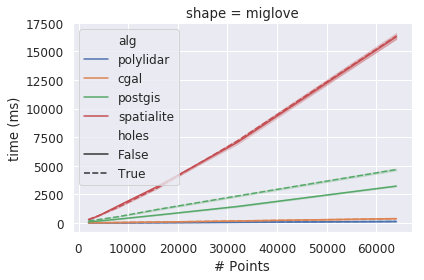

In [4]:
# fig = plt.Figure()
g = sns.relplot(x="points", y="time", hue="alg", style='holes',
            facet_kws=dict(sharex=True, legend_out=False),col="shape",
            kind="line", legend='brief', data=df_all_section,
            height=4, aspect=1.5)
g.set_ylabels("time (ms)")
g.set_xlabels("# Points")
# g.ax.legend(loc=2)
# g.despine(left=True)
# plt.legend(loc='upper left')
g.savefig('assets/pics/compare_algs_time.pdf')
# g.set(yscale="log")

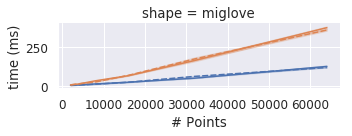

In [5]:
df_all_poly_cgal = df_all_section[df_all_section.alg.isin(['polylidar', 'cgal'])]

g = sns.relplot(x="points", y="time", hue="alg", style='holes',
            facet_kws=dict(sharex=True, legend_out=True),col="shape",
            kind="line", legend=False, data=df_all_poly_cgal,
            height=2, aspect=2.5)
g.set_ylabels("time (ms)")
g.set_xlabels("# Points")
# g.ax.legend(loc=2)
# g.despine(left=True)
# plt.legend(loc='upper left')
g.savefig('assets/pics/compare_algs_time_poly_cgal.pdf')

In [135]:
def add_proper_legend(p, ax):
    p.legend='brief'
    p.add_legend_data(ax)
    legend_data = dict(p.legend_data)
    # Delete the parts of the legend we dont want
    for to_del in [True, False, 'alg', 'holes']:
        del legend_data[to_del]
    # Create the legend
    labels, handles = list(zip(*legend_data.items()))
    ax.legend(handles, labels)

<IPython.core.display.Javascript object>


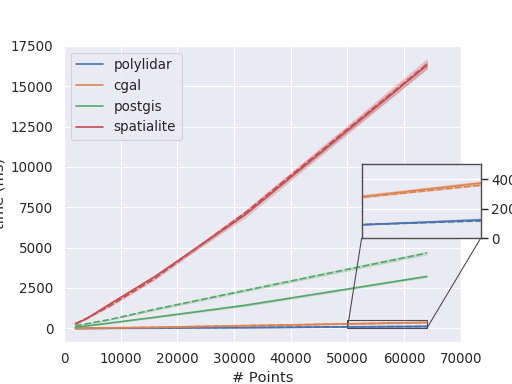

In [149]:
# fig = plt.Figure()
df_mi = df_all_section[df_all_section['shape'].isin(['miglove'])]
line_kwargs = dict(estimator="mean", ci=95, n_boot=1000, dashes=True,
             sort=True, err_style="band", err_kws=None)

p = _LinePlotter(x="points", y="time", hue="alg", style='holes',legend='brief', data=df_mi, **line_kwargs)
ax = plt.gca()
p.plot(ax, {})
# Hacky way to create the legend that we want
# have seaborn get the artist handles
add_proper_legend(p, ax)


ax.set_ylabel("time (ms)")
ax.set_xlabel("# Points")
ax.set_title('')
# ax = g.facet_axis(0,0)
ax.set_xlim([0, 70000])

# Add inset zoomed in axes
axins = ax.inset_axes((0.75,0.35,.3,.25))
# axins = zoomed_inset_axes(ax,1.0,loc=1) # zoom=6
x1,x2,y1,y2 = 50000, 64000, 0, 500
axins.set_xlim(x1,x2)
axins.set_ylim(y1,y2)
axins.set_xticks([])
axins.set_yticks([0, 200, 400])
axins.yaxis.tick_right()

mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.3")
sns.lineplot(x='points', y='time', hue='alg', style='holes', legend=False, data=df_all_poly_cgal, ax=axins)
axins.set_xlabel('')
axins.set_ylabel('')
for spine in axins.spines.values():
    spine.set_edgecolor('0.3')


plt.savefig('assets/pics/compare_algs_time_inset.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


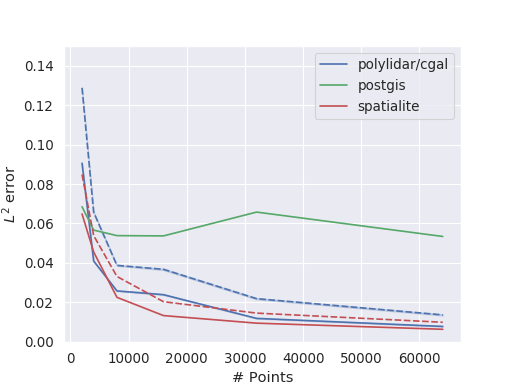

In [152]:
df_all_section_comb_poly_cgal =  df_mi.replace('polylidar', 'polylidar/cgal')
df_all_section_comb_poly_cgal =  df_all_section_comb_poly_cgal.replace('cgal', 'polylidar/cgal')

palette = {'polylidar/cgal': current_palette[0], 'postgis': current_palette[2], 'spatialite': current_palette[3]}

p = _LinePlotter(x="points", y="l2_norm", hue="alg", style='holes', palette=palette, legend=False, data=df_all_section_comb_poly_cgal, **line_kwargs)
ax = plt.gca()
p.plot(ax, {})
add_proper_legend(p, ax)

# g = sns.relplot(x="points", y="l2_norm", hue="alg", style='holes', palette=palette,
#             facet_kws=dict(sharex=True, legend_out=False, ylim=(0, 0.15)),col="shape",
#             kind="line", legend="full", data=df_all_section_comb_poly_cgal,
#             height=4, aspect=1.5)
ax.set_title('')
ax.set_ylabel(r'$L^2$ error')
ax.set_xlabel("# Points")
ax.set_ylim([0, 0.15])
plt.savefig('assets/pics/compare_algs_accuracy.pdf', bbox_inches='tight')
# g.set(yscale="log")

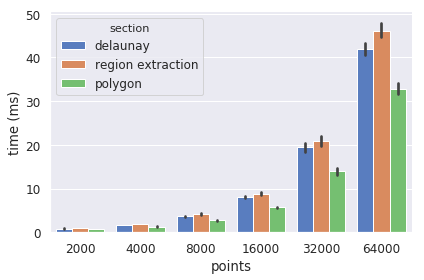

In [8]:
fig = plt.Figure((5,5))
df_pl_sec = df_pl_sec.replace('mesh', 'region extraction')
g = sns.catplot(x="points", y="time", hue="section", data=df_pl_sec, kind="bar", palette="muted",
                hue_order=["delaunay", "region extraction", "polygon"],  height=4, aspect=1.5, legend_out=False)

g.set_ylabels("time (ms)")
g.savefig('assets/pics/polylidar_decomposed.pdf')
# g.set(yscale="log")
# g.savefig("imgs/timing_results.pdf")

In [9]:
df_pl_sec_miglove = df_pl_sec[df_pl_sec['shape'] == 'miglove']

df_new = df_pl_sec_miglove.groupby([df_pl_sec_miglove['section'], df_pl_sec_miglove['points']]).mean()
df_new = df_new.reset_index()
df_delaunay = df_new[df_new['section'] == 'delaunay']
df_mesh = df_new[df_new['section'] == 'mesh']
df_polygon = df_new[df_new['section'] == 'polygon']

delaunay_diff = df_delaunay['time'].pct_change().reset_index()
mesh_diff = df_mesh['time'].pct_change().reset_index()
polygon_diff = df_polygon['time'].pct_change().reset_index()

values = []
names = ['delaunay_PctChange', 'mesh_PctChange', 'polygon_PctChange']
values.append(delaunay_diff.values[1:,1])
values.append(mesh_diff.values[1:, 1])
values.append(polygon_diff.values[1:, 1])

pd.DataFrame.from_items(zip(names, values))



/home/jeremy/miniconda3/envs/concave/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
